# Machine Learning with Spark

## Introduction

You've now explored how to perform operations on Spark RDDs for simple MapReduce tasks. Luckily, there are far more advanced use cases for Spark, and many of them are found in the `ml` library, which we are going to explore in this lesson.


## Objectives

You will be able to: 

- Load and manipulate data using Spark DataFrames  
- Define estimators and transformers in Spark ML 
- Create a Spark ML pipeline that transforms data and runs over a grid of hyperparameters 



## A Tale of Two Libraries

If you look at the PySpark documentation, you'll notice that there are two different libraries for machine learning, [mllib](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html) and [ml](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html). These libraries are extremely similar to one another, the only difference being that the `mllib` library is built upon the RDDs you just practiced using; whereas, the `ml` library is built on higher level Spark DataFrames, which has methods and attributes similar to pandas. Spark has stated that in the future, it is going to devote more effort to the `ml` library and that `mllib` will become deprecated. It's important to note that these libraries are much younger than pandas and scikit-learn and there are not as many features present in either.

## Spark DataFrames

In the previous lessons, you were introduced to SparkContext as the primary way to connect with a Spark Application. Here, we will be using SparkSession, which is from the [sql](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html) component of PySpark. The SparkSession acts the same way as SparkContext; it is a bridge between Python and the Spark Application. It's just built on top of the Spark SQL API, a higher-level API than RDDs. In fact, a SparkContext object is spun up around which the SparkSession object is wrapped. Let's go through the process of manipulating some data here. For this example, we're going to be using the [Forest Fire dataset](https://archive.ics.uci.edu/ml/datasets/Forest+Fires) from UCI, which contains data about the area burned by wildfires in the Northeast region of Portugal in relation to numerous other factors.

To begin with, let's create a SparkSession so that we can spin up our spark application. 

In [1]:
# importing the necessary libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
# sc = SparkContext('local[*]')
# spark = SparkSession(sc)

To create a SparkSession: 

In [2]:
spark = SparkSession.builder.master('local').getOrCreate()

Now, we'll load the data into a PySpark DataFrame: 

In [3]:
## reading in pyspark df
spark_df = spark.read.csv('./forestfires.csv', header='true', inferSchema='true')

## observing the datatype of df
type(spark_df)

pyspark.sql.dataframe.DataFrame

You'll notice that some of the methods are extremely similar or the same as those found within Pandas.

In [6]:
spark_df.head(5)

[Row(X=7, Y=5, month='mar', day='fri', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0),
 Row(X=7, Y=4, month='oct', day='tue', FFMC=90.6, DMC=35.4, DC=669.1, ISI=6.7, temp=18.0, RH=33, wind=0.9, rain=0.0, area=0.0),
 Row(X=7, Y=4, month='oct', day='sat', FFMC=90.6, DMC=43.7, DC=686.9, ISI=6.7, temp=14.6, RH=33, wind=1.3, rain=0.0, area=0.0),
 Row(X=8, Y=6, month='mar', day='fri', FFMC=91.7, DMC=33.3, DC=77.5, ISI=9.0, temp=8.3, RH=97, wind=4.0, rain=0.2, area=0.0),
 Row(X=8, Y=6, month='mar', day='sun', FFMC=89.3, DMC=51.3, DC=102.2, ISI=9.6, temp=11.4, RH=99, wind=1.8, rain=0.0, area=0.0)]

In [5]:
spark_df.columns

['X',
 'Y',
 'month',
 'day',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'area']

Selecting multiple columns is similar as well: 

In [12]:
spark_df[['month','day','rain']]

DataFrame[month: string, day: string, rain: double]

In [13]:
spark_df[['month','day','rain']].head(5)

[Row(month='mar', day='fri', rain=0.0),
 Row(month='oct', day='tue', rain=0.0),
 Row(month='oct', day='sat', rain=0.0),
 Row(month='mar', day='fri', rain=0.2),
 Row(month='mar', day='sun', rain=0.0)]

But selecting one column is different. If you want to maintain the methods of a spark DataFrame, you should use the `.select()` method. If you want to just select the column, you can use the same method you would use in pandas (this is primarily what you would use if you're attempting to create a boolean mask). 

In [14]:
d = spark_df.select('rain')

In [15]:
spark_df['rain']

Column<b'rain'>

Let's take a look at all of our data types in this dataframe

In [16]:
spark_df.dtypes

[('X', 'int'),
 ('Y', 'int'),
 ('month', 'string'),
 ('day', 'string'),
 ('FFMC', 'double'),
 ('DMC', 'double'),
 ('DC', 'double'),
 ('ISI', 'double'),
 ('temp', 'double'),
 ('RH', 'int'),
 ('wind', 'double'),
 ('rain', 'double'),
 ('area', 'double')]

In [18]:
spark_df.summary()

DataFrame[summary: string, X: string, Y: string, month: string, day: string, FFMC: string, DMC: string, DC: string, ISI: string, temp: string, RH: string, wind: string, rain: string, area: string]

## Aggregations with our DataFrame

Let's investigate to see if there is any correlation between what month it is and the area of fire: 

In [19]:
spark_df_months = spark_df.groupBy('month').agg({'area': 'mean'})
spark_df_months

DataFrame[month: string, avg(area): double]

Notice how the grouped DataFrame is not returned when you call the aggregation method. Remember, this is still Spark! The transformations and actions are kept separate so that it is easier to manage large quantities of data. You can perform the transformation by calling `.collect()`: 

In [20]:
spark_df_months.collect()

[Row(month='jun', avg(area)=5.841176470588234),
 Row(month='aug', avg(area)=12.489076086956521),
 Row(month='may', avg(area)=19.24),
 Row(month='feb', avg(area)=6.275),
 Row(month='sep', avg(area)=17.942616279069753),
 Row(month='mar', avg(area)=4.356666666666667),
 Row(month='oct', avg(area)=6.638),
 Row(month='jul', avg(area)=14.3696875),
 Row(month='nov', avg(area)=0.0),
 Row(month='apr', avg(area)=8.891111111111112),
 Row(month='dec', avg(area)=13.33),
 Row(month='jan', avg(area)=0.0)]

As you can see, there seem to be larger area fires during what would be considered the summer months in Portugal. On your own, practice more aggregations and manipulations that you might be able to perform on this dataset. 

In [24]:
spark_df.stat.corr('temp', 'area')

0.09784410734168436

In [27]:
temp = spark_df.select('temp').collect()
temp

[Row(temp=8.2),
 Row(temp=18.0),
 Row(temp=14.6),
 Row(temp=8.3),
 Row(temp=11.4),
 Row(temp=22.2),
 Row(temp=24.1),
 Row(temp=8.0),
 Row(temp=13.1),
 Row(temp=22.8),
 Row(temp=17.8),
 Row(temp=19.3),
 Row(temp=17.0),
 Row(temp=21.3),
 Row(temp=26.4),
 Row(temp=22.9),
 Row(temp=15.1),
 Row(temp=16.7),
 Row(temp=15.9),
 Row(temp=9.3),
 Row(temp=18.3),
 Row(temp=19.1),
 Row(temp=21.0),
 Row(temp=19.5),
 Row(temp=23.7),
 Row(temp=16.3),
 Row(temp=19.0),
 Row(temp=19.4),
 Row(temp=30.2),
 Row(temp=22.8),
 Row(temp=25.4),
 Row(temp=11.2),
 Row(temp=20.6),
 Row(temp=17.7),
 Row(temp=21.2),
 Row(temp=18.2),
 Row(temp=21.7),
 Row(temp=11.3),
 Row(temp=17.8),
 Row(temp=14.1),
 Row(temp=23.3),
 Row(temp=18.4),
 Row(temp=16.6),
 Row(temp=19.6),
 Row(temp=12.9),
 Row(temp=25.9),
 Row(temp=14.7),
 Row(temp=23.0),
 Row(temp=11.8),
 Row(temp=11.0),
 Row(temp=20.8),
 Row(temp=21.5),
 Row(temp=20.4),
 Row(temp=20.4),
 Row(temp=17.6),
 Row(temp=27.7),
 Row(temp=17.8),
 Row(temp=13.8),
 Row(temp=13.9),
 

In [32]:
# Finding number of rows
len(temp)

517

In [35]:
import pandas as pd

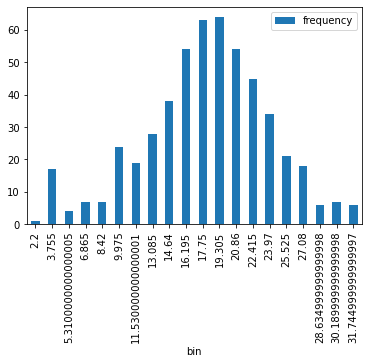

In [38]:
temp_histogram = spark_df.select('temp').rdd.flatMap(lambda x: x).histogram(20)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*temp_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

In [47]:
import numpy as np

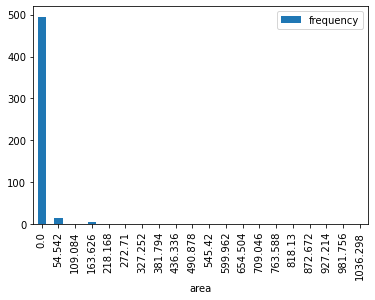

In [53]:
area_histogram = spark_df.select('area').rdd.flatMap(lambda x: x).histogram(20)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(np.array(area_histogram[0]).round(3), np.array(area_histogram[1]).round(3)) ), 
    columns=['area', 'frequency']
).set_index(
    'area'
).plot(kind='bar');

## Boolean Masking 

Boolean masking also works with PySpark DataFrames just like Pandas DataFrames, the only difference being that the `.filter()` method is used in PySpark. To try this out, let's compare the amount of fire in those areas with absolutely no rain to those areas that had rain.

In [54]:
no_rain = spark_df.filter(spark_df['rain'] == 0.0)
some_rain = spark_df.filter(spark_df['rain'] > 0.0)

Now, to perform calculations to find the mean of a column, we'll have to import functions from `pyspark.sql`. As always, to read more about them, check out the [documentation](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions).

In [55]:
from pyspark.sql.functions import mean

print('no rain fire area: ', no_rain.select(mean('area')).show(),'\n')

print('some rain fire area: ', some_rain.select(mean('area')).show(),'\n')

+------------------+
|         avg(area)|
+------------------+
|13.023693516699408|
+------------------+

no rain fire area:  None 

+---------+
|avg(area)|
+---------+
|  1.62375|
+---------+

some rain fire area:  None 



Yes there's definitely something there! Unsurprisingly, rain plays in a big factor in the spread of wildfire.

Let's obtain data from only the summer months in Portugal (June, July, and August). We can also do the same for the winter months in Portugal (December, January, February).

In [56]:
summer_months = spark_df.filter(spark_df['month'].isin(['jun','jul','aug']))
winter_months = spark_df.filter(spark_df['month'].isin(['dec','jan','feb']))

print('summer months fire area', summer_months.select(mean('area')).show())
print('winter months fire areas', winter_months.select(mean('area')).show())

+------------------+
|         avg(area)|
+------------------+
|12.262317596566525|
+------------------+

summer months fire area None
+-----------------+
|        avg(area)|
+-----------------+
|7.918387096774193|
+-----------------+

winter months fire areas None


## Machine Learning

Now that we've performed some data manipulation and aggregation, lets get to the really cool stuff, machine learning! PySpark states that they've used scikit-learn as an inspiration for their implementation of a machine learning library. As a result, many of the methods and functionalities look similar, but there are some crucial distinctions. There are three main concepts found within the ML library:

`Transformer`: An algorithm that transforms one PySpark DataFrame into another DataFrame. 

`Estimator`: An algorithm that can be fit onto a PySpark DataFrame that can then be used as a Transformer. 

`Pipeline`: A pipeline very similar to an `sklearn` pipeline that chains together different actions.

The reasoning behind this separation of the fitting and transforming step is because Spark is lazily evaluated, so the 'fitting' of a model does not actually take place until the Transformation action is called. Let's examine what this actually looks like by performing a regression on the Forest Fire dataset. To start off with, we'll import the necessary libraries for our tasks.

In [58]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml import feature
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, OneHotEncoderModel

Looking at our data, one can see that all the categories are numerical except for day and month. We saw some correlation between the month and area burned in a fire, so we will include that in our model. The day of the week, however, is highly unlikely to have any effect on fire, so we will drop it from the DataFrame.

In [59]:
fire_df = spark_df.drop('day')
fire_df.head()

Row(X=7, Y=5, month='mar', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0)

In order for us to run our model, we need to turn the months variable into a dummy variable. In `ml` this is a 2-step process that first requires turning the categorical variable into a numerical index (`StringIndexer`). Only after the variable is an integer can PySpark create dummy variable columns related to each category (`OneHotEncoderEstimator`). Your key parameters when using these `ml` estimators are: `inputCol` (the column you want to change) and `outputCol` (where you will store the changed column). Here it is in action: 

In [60]:
si = StringIndexer(inputCol='month', outputCol='month_num')
model = si.fit(fire_df)
new_df = model.transform(fire_df)
new_df.head()

Row(X=7, Y=5, month='mar', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0, month_num=2.0)

Note the small, but critical distinction between `sklearn`'s implementation of a transformer and PySpark's implementation. `sklearn` is more object oriented and Spark is more functional oriented.

In [61]:
## this is an estimator (an untrained transformer)
type(si)

pyspark.ml.feature.StringIndexer

In [62]:
## this is a transformer (a trained transformer)
type(model)

pyspark.ml.feature.StringIndexerModel

In [63]:
model.labels

['aug',
 'sep',
 'mar',
 'jul',
 'feb',
 'jun',
 'oct',
 'apr',
 'dec',
 'jan',
 'may',
 'nov']

In [64]:
new_df.head(4)

[Row(X=7, Y=5, month='mar', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0, month_num=2.0),
 Row(X=7, Y=4, month='oct', FFMC=90.6, DMC=35.4, DC=669.1, ISI=6.7, temp=18.0, RH=33, wind=0.9, rain=0.0, area=0.0, month_num=6.0),
 Row(X=7, Y=4, month='oct', FFMC=90.6, DMC=43.7, DC=686.9, ISI=6.7, temp=14.6, RH=33, wind=1.3, rain=0.0, area=0.0, month_num=6.0),
 Row(X=8, Y=6, month='mar', FFMC=91.7, DMC=33.3, DC=77.5, ISI=9.0, temp=8.3, RH=97, wind=4.0, rain=0.2, area=0.0, month_num=2.0)]

As you can see, we have created a new column called `'month_num'` that represents the month by a number. Now that we have performed this step, we can use Spark's version of `OneHotEncoder()` - `OneHotEncoderEstimator()`. Let's make sure we have an accurate representation of the months.

In [65]:
new_df.select('month_num').distinct().collect()

[Row(month_num=8.0),
 Row(month_num=0.0),
 Row(month_num=7.0),
 Row(month_num=1.0),
 Row(month_num=4.0),
 Row(month_num=11.0),
 Row(month_num=3.0),
 Row(month_num=2.0),
 Row(month_num=10.0),
 Row(month_num=6.0),
 Row(month_num=5.0),
 Row(month_num=9.0)]

In [66]:
## fitting and transforming the OneHotEncoderEstimator
ohe = feature.OneHotEncoder(inputCols=['month_num'], outputCols=['month_vec'], dropLast=True)
one_hot_encoded = ohe.fit(new_df).transform(new_df)
one_hot_encoded.head()

Row(X=7, Y=5, month='mar', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0, month_num=2.0, month_vec=SparseVector(11, {2: 1.0}))

Great, we now have a OneHotEncoded sparse vector in the `'month_vec'` column! Because Spark is optimized for big data, sparse vectors are used rather than entirely new columns for dummy variables because it is more space efficient. You can see in this first row of the DataFrame:  

`month_vec=SparseVector(11, {2: 1.0})` this indicates that we have a sparse vector of size 11 (because of the parameter `dropLast = True` in `OneHotEncoderEstimator()`) and this particular data point is the 2nd index of our month labels (march, based off the labels in the `model` StringEstimator transformer).  

The final requirement for all machine learning models in PySpark is to put all of the features of your model into one sparse vector. This is once again for efficiency sake. Here, we are doing that with the `VectorAssembler()` estimator.

In [67]:
features = ['X',
 'Y',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'month_vec']

target = 'area'

vector = VectorAssembler(inputCols=features, outputCol='features')
vectorized_df = vector.transform(one_hot_encoded)

In [68]:
vectorized_df.head()

Row(X=7, Y=5, month='mar', FFMC=86.2, DMC=26.2, DC=94.3, ISI=5.1, temp=8.2, RH=51, wind=6.7, rain=0.0, area=0.0, month_num=2.0, month_vec=SparseVector(11, {2: 1.0}), features=SparseVector(21, {0: 7.0, 1: 5.0, 2: 86.2, 3: 26.2, 4: 94.3, 5: 5.1, 6: 8.2, 7: 51.0, 8: 6.7, 12: 1.0}))

Great! We now have our data in a format that seems acceptable for the last step. It's time for us to actually fit our model to data! Let's fit a Random Forest Regression model to our data. Although there are still a bunch of other features in the DataFrame, it doesn't matter for the machine learning model API. All that needs to be specified are the names of the features column and the label column. 

In [69]:
## instantiating and fitting the model
rf_model = RandomForestRegressor(featuresCol='features', 
                                 labelCol='area', predictionCol='prediction').fit(vectorized_df)

In [71]:
fi = rf_model.featureImportances
fi

SparseVector(21, {0: 0.0402, 1: 0.0792, 2: 0.1915, 3: 0.083, 4: 0.0626, 5: 0.0877, 6: 0.1008, 7: 0.2076, 8: 0.1266, 9: 0.0, 10: 0.0006, 11: 0.0088, 12: 0.0, 13: 0.0101, 14: 0.0001, 15: 0.0, 16: 0.0003, 17: 0.0003, 18: 0.0004, 20: 0.0001})

In [72]:
fi.values

array([4.01645591e-02, 7.91615450e-02, 1.91545226e-01, 8.30360016e-02,
       6.25686874e-02, 8.77335184e-02, 1.00797983e-01, 2.07603376e-01,
       1.26648053e-01, 1.03204327e-05, 5.91104915e-04, 8.79509109e-03,
       1.55806164e-05, 1.01463202e-02, 5.22575564e-05, 8.07672333e-06,
       2.95801071e-04, 2.83186522e-04, 4.25840143e-04, 1.17471111e-04])

In [74]:
import matplotlib.pyplot as plt

In [84]:
feats

['X',
 'Y',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'aug',
 'sep',
 'mar',
 'jul',
 'feb',
 'jun',
 'oct',
 'apr',
 'dec',
 'jan',
 'may']

In [78]:
months = model.labels[:-1]
feats = features[:-1] + months

In [81]:
len(feats)

21

In [83]:
len(fi.values)

20

<BarContainer object of 21 artists>

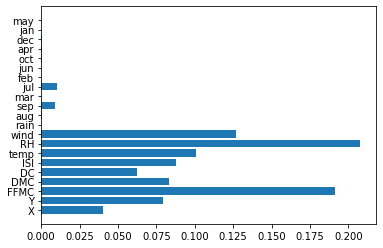

In [86]:
plt.barh(feats, fi)

In [ ]:
# interestingly, rain does not show up as very important on this chart. It is possible it's been generated wrong

In [88]:
## generating predictions
predictions = rf_model.transform(vectorized_df).select('area', 'prediction')
predictions.head(10)

[Row(area=0.0, prediction=7.280328878980681),
 Row(area=0.0, prediction=5.781804763878154),
 Row(area=0.0, prediction=6.507221852229412),
 Row(area=0.0, prediction=6.653435150269952),
 Row(area=0.0, prediction=6.193481304116105),
 Row(area=0.0, prediction=8.755514587244281),
 Row(area=0.0, prediction=6.805609020373389),
 Row(area=0.0, prediction=6.81881781760938),
 Row(area=0.0, prediction=7.175247475206646),
 Row(area=0.0, prediction=5.958641805945913)]

Now we can evaluate how well the model performed using `RegressionEvaluator`.

In [89]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='area')

In [90]:
## evaluating r^2
evaluator.evaluate(predictions,{evaluator.metricName: 'r2'})

0.7022071441377715

In [91]:
## evaluating mean absolute error
evaluator.evaluate(predictions,{evaluator.metricName: 'mae'})

12.902610711495765

## Putting it all in a Pipeline

We just performed a whole lot of transformations to our data. Let's take a look at all the estimators we used to create this model:

* `StringIndexer()` 
* `OneHotEnconderEstimator()` 
* `VectorAssembler()` 
* `RandomForestRegressor()` 

Once we've fit our model in the Pipeline, we're then going to want to evaluate it to determine how well it performs. We can do this with:

* `RegressionEvaluator()` 

We can streamline all of these transformations to make it much more efficient by chaining them together in a pipeline. The Pipeline object expects a list of the estimators prior set to the parameter `stages`.

In [92]:
# importing relevant libraries
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml import Pipeline

In [127]:
features

['X',
 'Y',
 'FFMC',
 'DMC',
 'DC',
 'ISI',
 'temp',
 'RH',
 'wind',
 'rain',
 'month_vec']

In [136]:
## instantiating all necessary estimator objects

string_indexer = StringIndexer(inputCol='month', outputCol='month_num', handleInvalid='keep'
                              )
one_hot_encoder = OneHotEncoder(inputCols=['month_num'], outputCols=['month_vec'], dropLast=True)
vector_assember = VectorAssembler(inputCols=features, outputCol='features')
random_forest = RandomForestRegressor(featuresCol='features', labelCol='area')
stages = [string_indexer, one_hot_encoder, vector_assember, random_forest]

# instantiating the pipeline with all them estimator objects
pipeline = Pipeline(stages=stages)

### Cross-validation 

You might have missed a critical step in the random forest regression above; we did not cross validate or perform a train/test split! Now we're going to fix that by performing cross-validation and also testing out multiple different combinations of parameters in PySpark's `GridSearch()` equivalent. To begin with, we will create a parameter grid that contains the different parameters we want to use in our model.

In [137]:
# creating parameter grid

params = ParamGridBuilder().addGrid(random_forest.maxDepth, [5, 10, 15])\
          .addGrid(random_forest.numTrees, [20 ,50, 100])\
          .build()

Let's take a look at the params variable we just built.

In [138]:
print('total combinations of parameters: ', len(params))

params[0]

total combinations of parameters:  9


{Param(parent='RandomForestRegressor_3f8d46ca1611', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5,
 Param(parent='RandomForestRegressor_3f8d46ca1611', name='numTrees', doc='Number of trees to train (>= 1).'): 20}

Now it's time to combine all the steps we've created to work in a single line of code with the `CrossValidator()` estimator.

In [139]:
## instantiating the evaluator by which we will measure our model's performance
reg_evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='area', metricName = 'mae')

## instantiating crossvalidator estimator
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=params, evaluator=reg_evaluator, parallelism=4)

In [140]:
## fitting crossvalidator
cross_validated_model = cv.fit(fire_df)

Now, let's see how well the model performed! Let's take a look at the average performance for each one of our 9 models. It looks like the optimal performance is an MAE around 23. Note that this is worse than our original model, but that's because our original model had substantial data leakage. We didn't do a train-test split!

In [141]:
cross_validated_model.avgMetrics

[22.45560157313931,
 21.316517672368192,
 21.955423849350918,
 23.402879836502784,
 22.46952673889089,
 22.78401856849183,
 23.509064614726675,
 22.59160413877237,
 22.861959442839265]

Now, let's take a look at the optimal parameters of our best performing model. The `cross_validated_model` variable is now saved as the best performing model from the grid search just performed. Let's look to see how well the predictions performed. As you can see, this dataset has a large number of areas of "0.0" burned. Perhaps, it would be better to investigate this problem as a classification task.

In [142]:
predictions = cross_validated_model.transform(spark_df)
predictions.select('prediction', 'area').show(300)

+------------------+-------+
|        prediction|   area|
+------------------+-------+
| 6.675377553238162|    0.0|
| 5.520751244437058|    0.0|
| 5.284643210716393|    0.0|
| 7.294348637267464|    0.0|
| 5.791393879869332|    0.0|
| 9.567330372907044|    0.0|
| 7.362614576468219|    0.0|
| 6.680545329819764|    0.0|
| 9.553465141383278|    0.0|
|15.198201591312248|    0.0|
| 6.823655524103516|    0.0|
| 7.410481589902721|    0.0|
| 7.172465294124433|    0.0|
|  8.18358769260519|    0.0|
|57.719915631790975|    0.0|
| 6.022728699076385|    0.0|
| 5.493307234662074|    0.0|
| 7.513052009052809|    0.0|
| 5.203463505452948|    0.0|
| 6.132543078665264|    0.0|
| 9.648638796109946|    0.0|
| 4.583261828311799|    0.0|
|  7.66479638164218|    0.0|
| 7.322743754191061|    0.0|
| 8.342317654270179|    0.0|
| 6.407951338832293|    0.0|
|7.9433393246697905|    0.0|
| 7.196594810922658|    0.0|
|10.081382320633677|    0.0|
|12.448587864887168|    0.0|
| 6.785755371491946|    0.0|
| 7.0044558390

Now let's go ahead and take a look at the feature importances of our random forest model. In order to do this, we need to unroll our pipeline to access the random forest model. Let's start by first checking out the `.bestModel` attribute of our `cross_validated_model`. 

In [143]:
type(cross_validated_model.bestModel)

pyspark.ml.pipeline.PipelineModel

`ml` is treating the entire pipeline as the best performing model, so we need to go deeper into the pipeline to access the random forest model within it. Previously, we put the random forest model as the final "stage" in the stages variable list. Let's look at the `.stages` attribute of the `.bestModel`.

In [144]:
cross_validated_model.bestModel.stages

[StringIndexerModel: uid=StringIndexer_80f080ee902a, handleInvalid=keep,
 OneHotEncoderModel: uid=OneHotEncoder_fa0d19058f13, dropLast=true, handleInvalid=error, numInputCols=1, numOutputCols=1,
 VectorAssembler_61612d8db64b,
 RandomForestRegressionModel: uid=RandomForestRegressor_3f8d46ca1611, numTrees=50, numFeatures=22]

Perfect! There's the RandomForestRegressionModel, represented by the last item in the stages list. Now, we should be able to access all the attributes of the random forest regressor.

In [145]:
optimal_rf_model = cross_validated_model.bestModel.stages[3]

In [146]:
optimal_rf_model.featureImportances

SparseVector(22, {0: 0.0988, 1: 0.0958, 2: 0.0791, 3: 0.1522, 4: 0.1009, 5: 0.0511, 6: 0.1363, 7: 0.1035, 8: 0.1233, 9: 0.0, 10: 0.0065, 11: 0.0404, 13: 0.0068, 14: 0.0002, 15: 0.0033, 16: 0.0001, 17: 0.0004, 18: 0.0001, 20: 0.0011})

In [147]:
lbls = cross_validated_model.bestModel.stages[0].labels
lbls

['aug',
 'sep',
 'mar',
 'jul',
 'feb',
 'jun',
 'oct',
 'apr',
 'dec',
 'jan',
 'may',
 'nov']

In [148]:
feats = features[:-1] + lbls[:-1]
len(feats)

21

<BarContainer object of 22 artists>

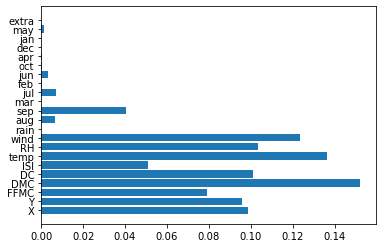

In [149]:
plt.barh(feats + ['extra'], optimal_rf_model.featureImportances)

In [150]:
optimal_rf_model.getNumTrees

50

## Summary

In this lesson, you learned about PySpark's DataFrames, machine learning models, and pipelines. With the use of a pipeline, you can train a huge number of models simultaneously, saving you a substantial amount of time and effort. Up next, you will have a chance to build a PySpark machine learning pipeline of your own with a classification problem!